g:\My Drive\projects\21_09_kmooc_ai_exercise\joy.py:669: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  fig.add_subplot(row, ncols, i + 1)


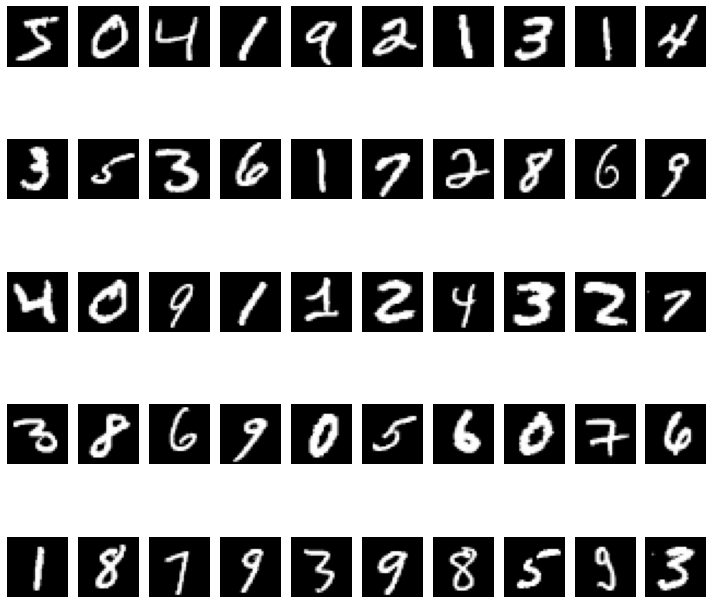

In [10]:
import joy
import numpy as np
(X,y), (Xt, yt) = joy.load_mnist() 

X_std = X[:]
X_std = np.asfarray(X)/255.0 * 0.99 + 0.01 #normalize
#print(X_std[0])

joy.show_mnist_grid(X_std.reshape(-1,28,28)[:50])

In [11]:
def one_hot_encoding(y, n_y, modified = True):
    yhot = np.eye(n_y)[np.array(y, dtype = 'int32').flatten()]
    if modified:
        yhot[yhot == 0] = 0.01
        yhot[yhot == 1] = 0.99
    return yhot

In [17]:
class MnistBGD_LS(object):

    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 100, random_seed=1):

        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1 
                
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0)
        A1 = self.g(Z1)
        Z2 = np.dot(self.W2, A1)
        A2 = self.g(Z2)
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        self.cost_ = []
        m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)
        

        learning_schedule = np.linspace(self.eta, 0.0001, self.epochs)
        

        for epoch in range(self.epochs):
            if (epoch) % 100 == 0:
                print('Training epoch {}/{}.'.format(epoch + 1, self.epochs))

            A0 = np.array(X, ndmin=2).T  
            Y0 = np.array(Y, ndmin=2).T

            Z1, A1, Z2, A2 = self.forpass(A0)

            E2 = Y0 - A2 
            E1 = np.dot(self.W2.T, E2) 


            dZ2 = E2 * self.g_prime(Z2)   
            dZ1 = E1 * self.g_prime(Z1)  
      
            self.W2 += self.eta * np.dot(dZ2, A1.T) / m_samples     
            self.W1 += self.eta * np.dot(dZ1, A0.T) / m_samples     

            self.cost_.append(np.sqrt(np.sum(E2 * E2)))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T      
        Z1, A1, Z2, A2 = self.forpass(A0)   
        return A2                                       

    def g(self, x):         
        x = np.clip(x, -500, 500)  
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):             
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):      
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100
    
    def evaluate_onebyone(self, Xtest, ytest):
        m_samples = len(ytest)
        scores = 0
        for m in range(m_samples):
            A2 = nn.predict(Xtest[m])
            yhat = np.argmax(A2)
            if yhat == ytest[m]:
                scores += 1

        return scores/m_samples * 100

In [18]:
(X, y), (Xtest, ytest) = joy.load_mnist()
X, y = X[:1000], y[:1000]
Xtest, ytest = Xtest[:100], ytest[:100]
nn = MnistBGD_LS(784, 100, 10, eta = 0.1, epochs = 1000)
nn.fit(X, y)
accuracy = nn.evaluate(Xtest, ytest)
print('Accuracy {}%'.format(accuracy))

Training epoch 1/1000.
Training epoch 101/1000.
Training epoch 201/1000.
Training epoch 301/1000.
Training epoch 401/1000.
Training epoch 501/1000.
Training epoch 601/1000.
Training epoch 701/1000.
Training epoch 801/1000.
Training epoch 901/1000.
Accuracy 77.0%


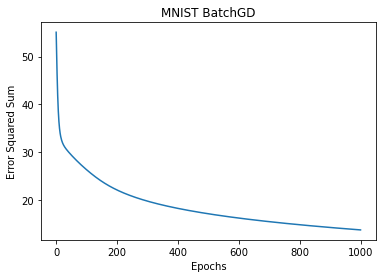

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.title('MNIST BatchGD')
plt.xlabel('Epochs')
plt.ylabel('Error Squared Sum')
plt.show()

In [20]:
class MnistSGD(object):
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 1, random_seed=1):
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1
        
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0)    
        A1 = self.g(Z1)               
        Z2 = np.dot(self.W2, A1) 
        A2 = self.g(Z2)              
        return Z1, A1, Z2, A2

    def fit(self, X, y): 
        self.cost_ = []
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.n_y)   

        
        for epoch in range(self.epochs):
            print('Training epoch {}/{}'.format(epoch+1, self.epochs))
            
            for m in range(self.m_samples):            

                A0 = np.array(X[m], ndmin=2).T   
                Y0 = np.array(Y[m], ndmin=2).T 
                Z1, A1, Z2, A2 = self.forpass(A0)      

                E2 = Y0 - A2                   
                E1 = np.dot(self.W2.T, E2)        

                dZ2 = E2 * self.g_prime(Z2)       
                dZ1 = E1 * self.g_prime(Z1)     


                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)    
                
                self.cost_.append(np.sqrt(np.sum(E2 * E2)))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T      
        Z1, A1, Z2, A2 = self.forpass(A0) 
        return A2                                       

    def g(self, x): 
        x = np.clip(x, -500, 500)  
        return 1.0/(1.0+np.exp(-x))

    
    def g_prime(self, x):  
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest): 
        m_samples = len(ytest)  
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores = np.sum(yhat == ytest)
        return scores/m_samples * 100
        
    def evaluate_onebyone(self, Xtest, ytest):
        m_samples = len(ytest)
        scores = 0
        for m in range(m_samples):
            A2 = self.predict(Xtest[m])
            yhat = np.argmax(A2)
            if yhat == ytest[m]:
                scores += 1
        return scores/m_samples * 100

In [21]:
import joy 
(X, y), (Xtest, ytest) = joy.load_mnist()

nn = MnistSGD(784, 100, 10, eta = 0.1, epochs = 20)
nn.fit(X[:1000], y[:1000])
acy = nn.evaluate(Xtest[:200], ytest[:200])
print('Accuracy {}%'.format(acy))

Training epoch 1/20
Training epoch 2/20
Training epoch 3/20
Training epoch 4/20
Training epoch 5/20
Training epoch 6/20
Training epoch 7/20
Training epoch 8/20
Training epoch 9/20
Training epoch 10/20
Training epoch 11/20
Training epoch 12/20
Training epoch 13/20
Training epoch 14/20
Training epoch 15/20
Training epoch 16/20
Training epoch 17/20
Training epoch 18/20
Training epoch 19/20
Training epoch 20/20
Accuracy 87.0%


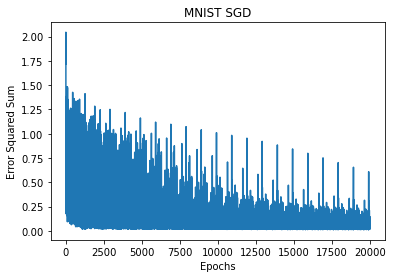

In [22]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.title('MNIST SGD')
plt.xlabel('Epochs')
plt.ylabel('Error Squared Sum')
plt.show()

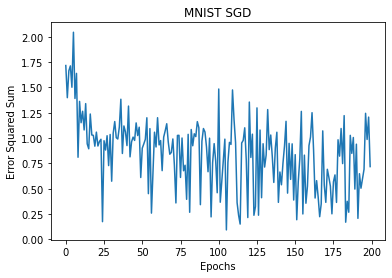

In [23]:
plt.plot(range(len(nn.cost_[:200])), nn.cost_[:200])
plt.title('MNIST SGD')
plt.xlabel('Epochs')
plt.ylabel('Error Squared Sum')
plt.show()